# Описание проекта

Необходимо подготовить прототип модели машинного обучения для компании, которая разрабатывает решения для промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Предоставлены данные с параметрами добычи и очистки. 

Модель призвана оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Необходимо:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.


---

#### План по выполнению проекта:  
1) Откроем файлы и проверим, что эффективность `rougher.output.recovery` обогащения рассчитана правильно.  
2) Подготовим данные для обучения и тестирования модели.  
3) Проанализируем признаки, недоступные в тестовой выборке.  
4) Изучим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.  
5) Сравним распределения размеров гранул сырья на обучающей и тестовой выборках.  
6) Исследуем суммарную концентрацию всех веществ на разных стадиях.  
7) Напишем функцию для вычисления итоговой sMAPE.  
8) Обучим разные модели и оценим их качество кросс-валидацией.   
9) Выберем лучшую модель и проверим её на тестовой выборке.  

---

Импортируем все необходимые для анализа и обучения библиотеки.

In [1]:
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
import numpy as np

from sklearn.impute import KNNImputer

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from scipy import stats as st

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

import seaborn as sns
from matplotlib.pyplot import figure

from sklearn.metrics import fbeta_score, make_scorer

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.size'] = 12

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

pd.set_option('display.max_columns', None)

import warnings # отключение предупреждений
warnings.filterwarnings('ignore')

# 1. Подготовка данных

### 1. Откроем файлы

In [3]:
for i in ('train', 'test', 'full'):
    path = 'datasets/gold_recovery_{}.csv'.format(i)
    df_name = 'gold_recovery_{}'.format(i)
    globals()[df_name] = pd.read_csv(path)

In [4]:
print(gold_recovery_train.info(), '\n')
print(gold_recovery_test.info(), '\n')
gold_recovery_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


Для проверки правильности расчета эффективности обогащения `rougher.output.recovery`, создадим копию обучающей выборки, в которой удалим строки с отсутствующими значениями. На этом этапе, для общего понимания, что в этом расчете нет ошибки, не будем заполнять пропущенные (NaN) значения. 

In [69]:
grt = gold_recovery_train.copy()
grt.dropna(inplace=True)

grt.shape

(11017, 87)

Напишем функцию для расчета эффективность обогащения и применим её.

In [70]:
def efficiency(col):
    C = col['rougher.output.concentrate_au']
    F=col['rougher.input.feed_au']
    T=col['rougher.output.tail_au']
    recovery = (C*(F-T))/(F*(C-T))*100
    return recovery

In [71]:
check_ror = efficiency(grt)
print(check_ror.describe(), '\n')

ror= grt['rougher.output.recovery']
print(ror.describe())

count    11017.000000
mean        82.741888
std         13.590523
min         -0.000000
25%         79.997468
50%         84.847754
75%         89.635149
max        100.000000
dtype: float64 

count    11017.000000
mean        82.741888
std         13.590523
min          0.000000
25%         79.997468
50%         84.847754
75%         89.635149
max        100.000000
Name: rougher.output.recovery, dtype: float64


При сравнении основных статистических данных видно, что эффективность обогащения рассчитана правильно.  
Для проверки, вычислим метрику MAE между нашими расчётами и значением признака.

In [72]:
mae = mean_absolute_error(check_ror, ror)
mae

9.555596961987514e-15

Значение MAE ничтожно мало, соответственно, расчет эффективности обогащения `rougher.output.recovery` произведён верно.  

### 2. Подготовим данные для обучения

Для начала выясним объем пропущенных значений (NaN) в обучающей выборке. Для этого применим функцию, которая покажет сколько в % пропущенных значений.

In [73]:
def missing_values_table(df):
        mis_val = df.isnull().sum() # общее количество пропусков
        mis_val_percent = 100 * df.isnull().sum() / len(df) # пропуски в %
        
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1) # составление таблицы
        
        # переименование столбцов
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Сортировка по убыванию
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        print ("В выборке " + str(df.shape[1]) + " столбцов.\n"      
            "Из них " + str(mis_val_table_ren_columns.shape[0]) +
              " с пропущенными значениями.")
        
        return mis_val_table_ren_columns
    
    
missing_values_table(gold_recovery_train).head(10)

В выборке 87 столбцов.
Из них 85 с пропущенными значениями.


,Missing Values,% of Total Values
rougher.output.recovery,2573,15.3
rougher.output.tail_ag,2250,13.3
rougher.output.tail_au,2249,13.3
rougher.output.tail_sol,2249,13.3
secondary_cleaner.output.tail_sol,1986,11.8
rougher.input.floatbank11_xanthate,1904,11.3
final.output.recovery,1521,9.0
primary_cleaner.input.sulfate,1307,7.8
primary_cleaner.input.depressant,1262,7.5
rougher.calculation.au_pb_ratio,1242,7.4


Удалим пропуски в целевых столбцах `rougher.output.recovery` и `final.output.recovery`, т.к. эти NaN-ы связаны с аномальными значениями замеров.

In [74]:
gold_recovery_train.dropna(subset=['rougher.output.recovery', 'final.output.recovery'], inplace=True)

In [75]:
# pip install -U --user scikit-learn # для работы метода KNNImputer требуется обновить scikit-learn-0.22.2.post1

In [76]:
gold_recovery_train = gold_recovery_train.replace([np.inf, -np.inf], np.nan) # убирает возможные значения бесконечности (если есть)

imputer = KNNImputer(n_neighbors=2)
gold_recovery_train.loc[:, gold_recovery_train.columns != 'date'] = imputer.fit_transform(gold_recovery_train.loc[:, gold_recovery_train.columns != 'date'])

In [77]:
missing_values_table(gold_recovery_train).head(10)

В выборке 87 столбцов.
Из них 0 с пропущенными значениями.


,Missing Values,% of Total Values


В обучающей выборке пропусков нет.

Выясним объем пропусков в тестовой выборке и так же заполним их средними соседними значениями.

In [78]:
missing_values_table(gold_recovery_test).head()

В выборке 53 столбцов.
Из них 51 с пропущенными значениями.


,Missing Values,% of Total Values
rougher.input.floatbank11_xanthate,353,6.0
primary_cleaner.input.sulfate,302,5.2
primary_cleaner.input.depressant,284,4.8
rougher.input.floatbank10_sulfate,257,4.4
primary_cleaner.input.xanthate,166,2.8


In [79]:
gold_recovery_test = gold_recovery_test.replace([np.inf, -np.inf], np.nan)

imputer = KNNImputer(n_neighbors=2)
gold_recovery_test.loc[:, gold_recovery_test.columns != 'date'] = imputer.fit_transform(gold_recovery_test.loc[:, gold_recovery_test.columns != 'date'])

### 3. Проанализируем признаки, недоступные в тестовой выборке.

In [80]:
diff_2 = gold_recovery_train.drop(gold_recovery_test, axis=1) # разница между признаками обучающей и тестовой выборками
print(list(diff_2))
diff_2.shape

['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au', 'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb', 'final.output.tail_sol', 'final.output.tail_au', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_au', 'rougher.output.recovery', 'rougher.output.tail_ag', 'rougher.output.tail_pb', 'rougher.output.tail_sol', 'rougher.output.tai

(14149, 34)

Данные параметры недоступны в тестовой выборке, так как замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют вышеперечисленные признаки, которые есть в обучающей. Также в тестовом наборе нет целевых признаков.  
Эти признаки с итоговыми данными (`_.output._`) и выходными параметрами продуктов на каждом этапе технологического процесса.

In [81]:
gold_recovery_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

### 4. Исследуем, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

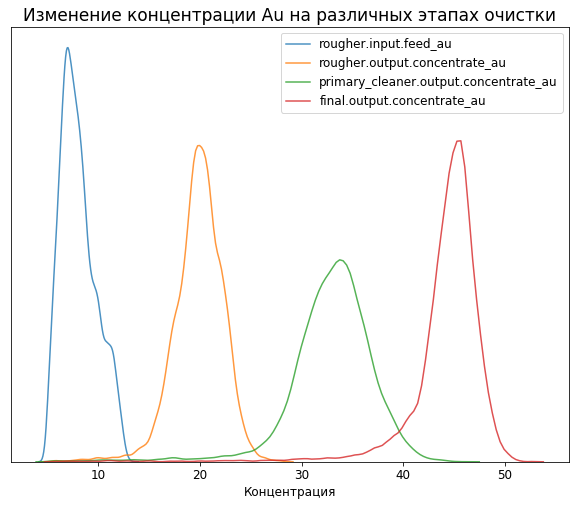

In [82]:
figsize(10, 8)

au1 = sns.kdeplot(gold_recovery_train['rougher.input.feed_au'], shade = False, clip=(5,55), alpha = 0.8);
au2 = sns.kdeplot(gold_recovery_train['rougher.output.concentrate_au'], shade = False, clip=(5,55), alpha = 0.8);
au3 = sns.kdeplot(gold_recovery_train['primary_cleaner.output.concentrate_au'], shade = False, clip=(5,55), alpha = 0.8);
au4 = sns.kdeplot(gold_recovery_train['final.output.concentrate_au'], shade = False, clip=(5,55), alpha = 0.8);

au1.set(yticks=[])
au2.set(yticks=[])
au3.set(yticks=[])
au4.set(yticks=[])
    
plt.xlabel('Концентрация', size = 12); 
plt.title('Изменение концентрации Au на различных этапах очистки', size = 17);

Хорошо видно, с каждым этапом очистки концентрация золота увеличивается.

Text(0.5, 1.0, 'Изменение концентрации Ag на различных этапах очистки')

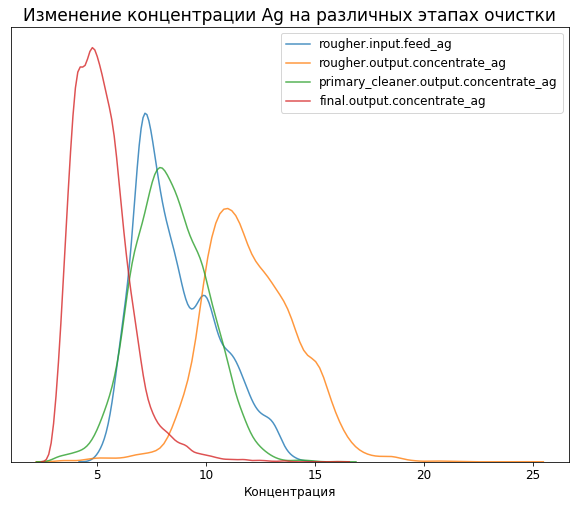

In [83]:
ag1 = sns.kdeplot(gold_recovery_train['rougher.input.feed_ag'], shade = False, clip=(5,55), alpha = 0.8);
ag2 = sns.kdeplot(gold_recovery_train['rougher.output.concentrate_ag'], shade = False, clip=(3,25), alpha = 0.8);
ag3 = sns.kdeplot(gold_recovery_train['primary_cleaner.output.concentrate_ag'], shade = False, clip=(3,25), alpha = 0.8);
ag4 = sns.kdeplot(gold_recovery_train['final.output.concentrate_ag'], shade = False, clip=(3,25), alpha = 0.8);

ag1.set(yticks=[])
ag2.set(yticks=[])
ag3.set(yticks=[])
ag4.set(yticks=[])
    
plt.xlabel('Концентрация', size = 12); 
plt.title('Изменение концентрации Ag на различных этапах очистки', size = 17)

Максимальная концентрация серебра достигается после флотации, затем этот параметр уменьшается.

Text(0.5, 1.0, 'Изменение концентрации Pb на различных этапах очистки')

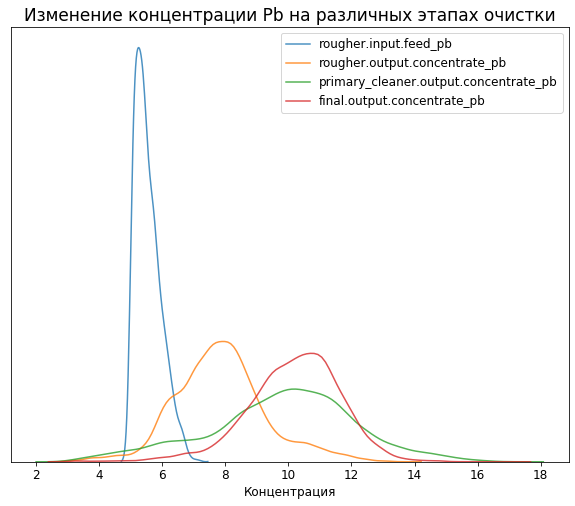

In [84]:
pb1 = sns.kdeplot(gold_recovery_train['rougher.input.feed_pb'], shade = False, clip=(5,55), alpha = 0.8);
pb2 = sns.kdeplot(gold_recovery_train['rougher.output.concentrate_pb'], shade = False, clip=(3,25), alpha = 0.8);
pb3 = sns.kdeplot(gold_recovery_train['primary_cleaner.output.concentrate_pb'], shade = False, clip=(3,25), alpha = 0.8);
pb4 = sns.kdeplot(gold_recovery_train['final.output.concentrate_pb'], shade = False, clip=(3,25), alpha = 0.8);

pb1.set(yticks=[])
pb2.set(yticks=[])
pb3.set(yticks=[])
pb4.set(yticks=[])

plt.xlabel('Концентрация', size = 12); 
plt.title('Изменение концентрации Pb на различных этапах очистки', size = 17)

Концентрация свинца увеличивается с каждым этапом очистки, но не так значительно, как это происходит с золотом. После первичного этапа очистки концентрация практически не изменилась, но увеличилось качество, т.е. увеличилось количество проб с большей концентрацией (график `final.output.concentrate_pb` (финальный концентрат) выше по оси Y и уже по оси Х, чем `primary_cleaner.output.concentrate_pb` (после первичного этапа очистки).  

### 5. Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. 

Изучим размер гранул перед и после флотации.

In [85]:
f_size_tr = gold_recovery_train.filter(like='size', axis=1)
f_size_t = gold_recovery_test.filter(like='size', axis=1)
print(f_size_tr.describe(), '\n')
print(f_size_t.describe())
# fsize_train = gold_recovery_train[['rougher.input.feed_size'], ['primary_cleaner.input.feed_size']]
# fsize_test = gold_recovery_test['rougher.input.feed_size', 'primary_cleaner.input.feed_size']

       primary_cleaner.input.feed_size  rougher.input.feed_size
count                     14149.000000             14149.000000
mean                          7.322310                60.142646
std                           0.614062                22.638726
min                           1.080000                 9.659576
25%                           6.960000                48.979988
50%                           7.290000                55.377622
75%                           7.700000                65.949832
max                          10.470000               484.967466 

       primary_cleaner.input.feed_size  rougher.input.feed_size
count                      5856.000000              5856.000000
mean                          7.264651                55.890660
std                           0.611526                22.704942
min                           5.650000                 0.046369
25%                           6.885625                43.867479
50%                           7.259333

Text(0.5, 1.0, 'rougher.input.feed_size')

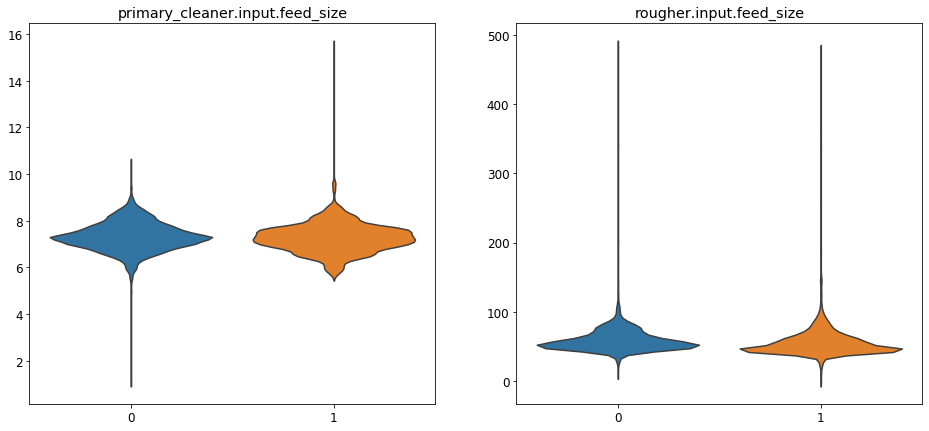

In [86]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
sns.violinplot(data=(f_size_tr['primary_cleaner.input.feed_size'], f_size_t['primary_cleaner.input.feed_size']), scale='width', inner=None, ax=ax1)
sns.violinplot(data=(f_size_tr['rougher.input.feed_size'], f_size_t['rougher.input.feed_size']), scale='width', inner=None, ax=ax2)

ax1.set_title('primary_cleaner.input.feed_size')
ax2.set_title('rougher.input.feed_size')

Из приведённых выше статистических данных и диаграмм видно, что распределения размеров гранул сырья на обучающей и тестовой выборках отличаются друг от друга незначительно.

### 6. Исследуем суммарную концентрацию всех веществ на разных стадиях.


Выделим концентрацию Au, Ag, Pb и Sol на каждом этапе очистки и просуммируем в столбец `_total`.  
Концентрация на стадии:  

- исходное сырьё (руда) -  `rougher.input.feed_`;
- после флотации (черновой концентрат) - `rougher.output.concentrate_`;
- после первичной очистки - `primary_cleaner.output.concentrate_`;
- финальный концентрат - `final.output.concentrate_`.

#### Обучающая выборка

In [87]:
raw_tot = gold_recovery_train.filter(like='rougher.input.feed_', axis=1)
raw_tot['raw_total'] = raw_tot.iloc[:,[0,1,4,5]].sum(axis=1) # суммарная концентрация всех веществ в обучающей выборке
gold_recovery_train['raw_total'] = raw_tot['raw_total'] # добавление столбца в обучающую выборку

rougher_tot = gold_recovery_train.filter(like='rougher.output.concentrate_', axis=1)
rougher_tot['rougher_total'] = rougher_tot.sum(axis=1) # суммарная концентрация всех веществ в обучающей выборке
gold_recovery_train['rougher_total'] = rougher_tot['rougher_total'] # добавление столбца в обучающую выборку

prim_tot = gold_recovery_train.filter(like='primary_cleaner.output.concentrate_', axis=1)
prim_tot['primary_total'] = prim_tot.sum(axis=1) # суммарная концентрация всех веществ в обучающей выборке
gold_recovery_train['primary_total'] = prim_tot['primary_total'] # добавление столбца в обучающую выборку

fin_tot = gold_recovery_train.filter(like='final.output.concentrate_', axis=1)
fin_tot['final_total'] = fin_tot.sum(axis=1) # суммарная концентрация всех веществ в обучающей выборке
gold_recovery_train['final_total'] = fin_tot['final_total'] # добавление столбца в обучающую выборку

raw_tot_t = gold_recovery_test.filter(like='rougher.input.feed_', axis=1) 
raw_tot_t['raw_total'] = raw_tot_t.iloc[:,[0,1,4,5]].sum(axis=1) # суммарная концентрация всех веществ в тест.выборке
gold_recovery_test['raw_total'] = raw_tot_t['raw_total'] # добавление столбца в тестовую выборку
raw_tot_t.head()

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,raw_total
0,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,72.871822
1,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,71.669225
2,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,73.202598
3,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,70.757057
4,11.327427,4.767383,488.248117,63.315324,41.269161,11.290425,68.654396


In [88]:
raw_tot.describe()

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,raw_total
count,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000
mean,8.579195,3.521209,473.864794,60.142646,36.296546,7.866577,56.263527
std,1.896284,1.071906,104.348979,22.638726,4.966961,1.919506,7.000103
min,0.010000,0.010000,0.012786,9.659576,0.010000,0.010000,0.040000
25%,7.132802,2.781136,420.605284,48.979988,34.095312,6.596217,52.591070
50%,8.156092,3.422800,499.449303,55.377622,37.012497,7.649138,56.627137
75%,9.918304,4.224092,547.326781,65.949832,39.415905,9.066976,60.772003
max,14.596026,7.142594,717.508837,484.967466,48.363177,13.126043,74.458253


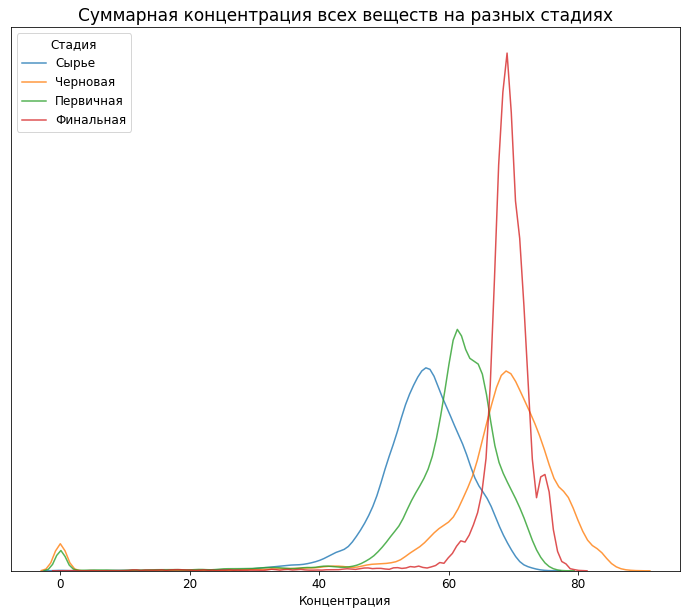

In [89]:
figsize(12, 10)

tot1 = sns.kdeplot(gold_recovery_train['raw_total'], shade = False, alpha = 0.8);
tot2 = sns.kdeplot(gold_recovery_train['rougher_total'], shade = False, alpha = 0.8);
tot3 = sns.kdeplot(gold_recovery_train['primary_total'], shade = False, alpha = 0.8);
tot4 = sns.kdeplot(gold_recovery_train['final_total'], shade = False, alpha = 0.8);

tot1.set(yticks=[])
tot2.set(yticks=[])
tot3.set(yticks=[])
tot4.set(yticks=[])

plt.legend(title='Стадия', loc='upper left', labels=['Cырье', 'Черновая', 'Первичная', 'Финальная'])
plt.xlabel('Концентрация', size = 12); 
plt.title('Суммарная концентрация всех веществ на разных стадиях', size = 17);

Статистические данные и графики говорят о том, что на каждом этапе присутствуют аномальные значения в суммарном распределении. Причём, осноные аномалии в около нулевом значении. Они могли возникнуть из-за ошибок или некорректной работы датчиков. В данном случае мы удалим «лишние» значения, руководствуясь определением экстремальных аномалий:  
- ниже первого квартиля − 3 ∗ интерквартильный размах.  
- выше третьего квартиля + 3 ∗ интерквартильный размах.  

Напишем функцию для удаления аномальных значений. 

In [90]:
def remv_outl(dfr, set):
    first_quartile = set.describe()['25%']
    third_quartile = set.describe()['75%']

    iqr = third_quartile - first_quartile # интерквартильный размах

    cleaned = dfr[(set > (first_quartile - 3 * iqr)) & (set < (third_quartile + 3 * iqr))]
    return cleaned.reset_index(drop=True, inplace=False)

In [91]:
gold_train_cleared = gold_recovery_train.copy()
gold_train_cleared = remv_outl(gold_train_cleared, gold_train_cleared['raw_total']) # удаления аномалий по суммарным значениям
gold_train_cleared = remv_outl(gold_train_cleared, gold_train_cleared['rougher_total'])
gold_train_cleared = remv_outl(gold_train_cleared, gold_train_cleared['primary_total'])
gold_train_cleared = remv_outl(gold_train_cleared, gold_train_cleared['final_total'])

gold_train_cleared.iloc[:,-4:] .describe()

,raw_total,rougher_total,primary_total,final_total
count,13028.000000,13028.000000,13028.000000,13028.000000
mean,56.533039,69.143800,61.846780,69.338104
std,6.350697,6.902259,5.583469,3.003869
min,28.179095,39.639975,37.243042,57.494126
25%,52.734549,65.540149,58.826216,67.731115
50%,56.692815,69.438813,62.073531,69.227986
75%,60.826485,73.571134,65.483888,71.035397
max,74.458253,87.273435,76.918076,80.210644


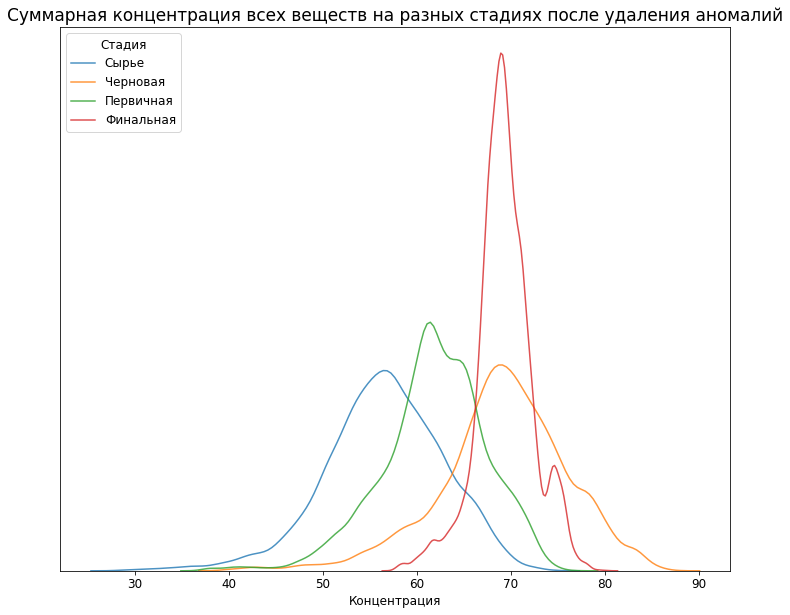

In [92]:
figsize(12, 10)

tot1 = sns.kdeplot(gold_train_cleared['raw_total'], clip=(-1, 100), shade = False, alpha = 0.8);
tot2 = sns.kdeplot(gold_train_cleared['rougher_total'],clip=(-1, 100), shade = False, alpha = 0.8);
tot3 = sns.kdeplot(gold_train_cleared['primary_total'], clip=(-1, 100), shade = False, alpha = 0.8);
tot4 = sns.kdeplot(gold_train_cleared['final_total'], clip=(-1, 100), shade = False, alpha = 0.8);

tot1.set(yticks=[])

plt.legend(title='Стадия', loc='upper left', labels=['Cырье', 'Черновая', 'Первичная', 'Финальная'])
plt.xlabel('Концентрация', size = 12); 
plt.title('Суммарная концентрация всех веществ на разных стадиях после удаления аномалий', size = 17);

#### Тестовая выборка

В тестовой выборке присутствуют только значения входного сырья. 

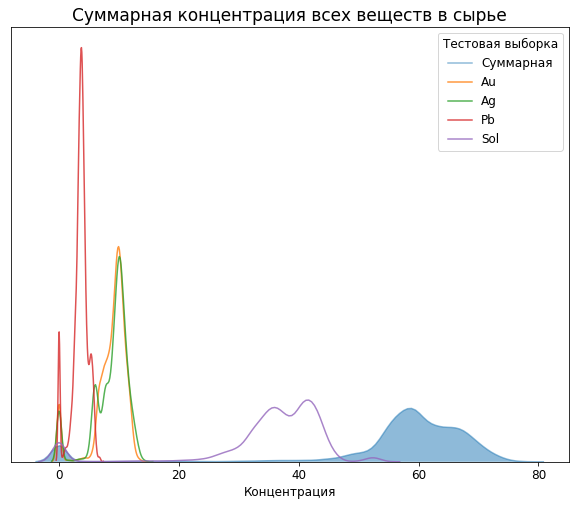

In [93]:
figsize(10, 8)

tott = sns.kdeplot(gold_recovery_test['raw_total'], shade = True, alpha = 0.5);
sns.kdeplot(gold_recovery_test['rougher.input.feed_au'],clip=(-1, 100), shade = False, alpha = 0.8);
sns.kdeplot(gold_recovery_test['rougher.input.feed_ag'], clip=(-1, 100), shade = False, alpha = 0.8);
sns.kdeplot(gold_recovery_test['rougher.input.feed_pb'], clip=(-1, 100), shade = False, alpha = 0.8);
sns.kdeplot(gold_recovery_test['rougher.input.feed_sol'], clip=(-1, 100), shade = False, alpha = 0.8);

tott.set(yticks=[])

plt.legend(title='Тестовая выборка', loc='upper right', labels=['Суммарная', 'Au', 'Ag', 'Pb', 'Sol'])
plt.xlabel('Концентрация', size = 12); 
plt.title('Суммарная концентрация всех веществ в сырье', size = 17);

Так же наблюдаем аномальные выбросы в нулевой зоне. Применим ту же функцию, удаляющую экстремальных аномалии.

In [94]:
gold_test_cleared = remv_outl(gold_recovery_test, gold_recovery_test['raw_total']) # после удаления аномальных значений

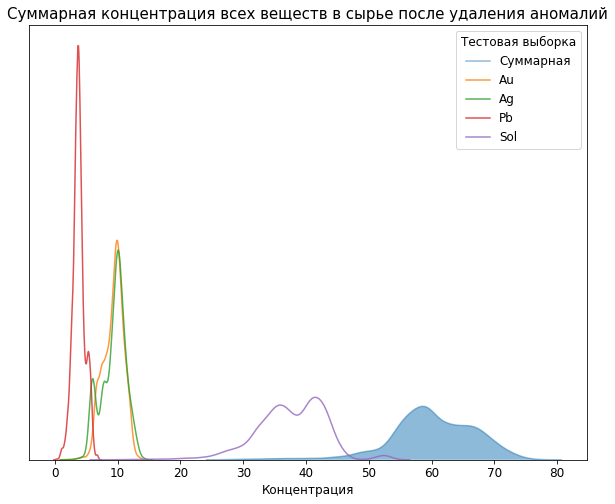

In [95]:
figsize(10, 8)

tott = sns.kdeplot(gold_test_cleared['raw_total'], shade = True, alpha = 0.5);
sns.kdeplot(gold_test_cleared['rougher.input.feed_au'],clip=(-1, 100), shade = False, alpha = 0.8);
sns.kdeplot(gold_test_cleared['rougher.input.feed_ag'], clip=(-1, 100), shade = False, alpha = 0.8);
sns.kdeplot(gold_test_cleared['rougher.input.feed_pb'], clip=(-1, 100), shade = False, alpha = 0.8);
sns.kdeplot(gold_test_cleared['rougher.input.feed_sol'], clip=(-1, 100), shade = False, alpha = 0.8);

tott.set(yticks=[])

plt.legend(title='Тестовая выборка', loc='upper right', labels=['Суммарная', 'Au', 'Ag', 'Pb', 'Sol'])
plt.xlabel('Концентрация', size = 12); 
plt.title('Суммарная концентрация всех веществ в сырье после удаления аномалий', size = 15);

In [96]:
print(gold_train_cleared.shape)
gold_test_cleared.shape

(13028, 91)


(5438, 54)

В обучающей и тестовой выборке были обнаружены и удалены аномальные значения в суммарном распределении.  

В обеих выборках в основном удалились аномальные значения в нулевой зоне (слева от среднего), т.к. минимальное значение в большинстве случаев меньше суммы первого квартиля + 3 интерквартильных размаха, а третий квартиль + 3 интерквартильных размаха больше максимального значения.  

### 7. Функция для вычисления итоговой sMAPE.

Так как необходимо спрогнозировать сразу две величины:  
- эффективность обогащения чернового концентрата `rougher.output.recovery`;
- эффективность обогащения финального концентрата `final.output.recovery'.  

А метрика итогового sMAPE складывается из sMAPE этих двух величин, то напишем 2 функции: для sMAPE и для итогового sMAPE. Соответственно, чем меньше значение sMAPE (особенно финального концентрата), тем меньше и лучше будет значение итогового sMAPE.

In [97]:
def smape(target, predict):
    return 100/len(target) * np.sum(2 * np.abs(predict - target) / (np.abs(target) + np.abs(predict)))

def fin_smape(smape_r, smape_f):
    return smape_r * 0.25 + smape_f * 0.75

### 8. Обучим разные модели и оценим их качество кросс-валидацией.

1) Так как в обучающей выборке на 34 признака больше, чем в тестовой (а проверять лучшую модель мы будем на тестовой), для обучения моделей уравняем количество признаков в выборках.  
2) Разделим признаки для обучения моделей и прогнозирования `rougher.output.recovery` и `final.output.recovery`.  
3) Проверим выборки на предмет того, что порядок признаков в обучающих и тестовых выборках одинаковый.  
4) Для оценки качества модели, помимо целевой метрики качества — sMAPE и метрик R2, MAE, для большей наглядности, будем использовать метрику средней абсолютной ошибки в процентах (Mean Absolute Percentage Error - MAPE). Так как пока этой метрики нет в библиотеке sklearn, напишем функию для расчета.

In [98]:
gold_train = gold_train_cleared.drop(diff_2, axis=1) # оставляем только те столбцы, которые есть в тестовой выборке
gold_train = gold_train.drop(['date', 'raw_total', 'rougher_total', 'primary_total', 'final_total'], axis=1) # уберём ненужные для обучения столбцы
gold_train.shape # выборка для целевого признака final.output.recovery

(13028, 52)

In [99]:
rougher_state = gold_train.filter(like='rougher.', axis=1) # выборка для целевого признака rougher.output.recovery
rougher_state.shape

(13028, 22)

In [100]:
y_rougher = gold_train_cleared['rougher.output.recovery'] # целевые признаки
y_final = gold_train_cleared['final.output.recovery']

In [101]:
gold_test_cleared = gold_test_cleared.merge(gold_recovery_full[['date','rougher.output.recovery','final.output.recovery']], on='date', how='left')
gold_test_cleared.dropna(subset=['rougher.output.recovery', 'final.output.recovery'], inplace=True) # удаление строк с отсутствующими целевыми признаками


y_rougher_test = gold_test_cleared['rougher.output.recovery'] # тестовый целевой признак 1
y_final_test = gold_test_cleared['final.output.recovery'] # тестовый целевой признак 2

gold_test = gold_test_cleared.drop(columns = ['date', 'raw_total', 'rougher.output.recovery','final.output.recovery'], axis=1)

rougher_test = gold_test.filter(like='rougher.', axis=1) # выборка для целевого признака rougher.output.recovery

In [102]:
correct_r = True
for i in range(len(rougher_state.columns)):
    if rougher_state.columns[i] != rougher_test.columns[i]:
        correct_r = False
        break

correct_f = True
for i in range(len(gold_train.columns)):
    if gold_train.columns[i] != gold_test.columns[i]:
        correct_f = False
        break
        
print(f'Порядок признаков в выборках "rougher" одинаковый: {correct_r}')
print(f'Порядок признаков в выборках "final" одинаковый: {correct_f}')

Порядок признаков в выборках "rougher" одинаковый: True
Порядок признаков в выборках "final" одинаковый: True


In [103]:
print('Обучающая выборка для целевого параметра "rougher.output":', rougher_state.shape)
print('Целевой признак "rougher.output" обучающей выборки:', y_rougher.shape, '\n')

print('Обучающая выборка для "final.output":', gold_train.shape)
print('Целевой признак "final.output" обучающей выборки:', y_final.shape, '\n')

print('Тестовая выборка для целевого параметра "rougher.output":',rougher_test.shape)
print('Целевой признак "rougher.output" тестовой выборки:', y_rougher_test.shape, '\n')

print('Тестовая выборка для целевого параметра "final.output":',gold_test.shape)
print('Целевой признак "final.output" тестовой выборки:', y_final_test.shape)

Обучающая выборка для целевого параметра "rougher.output": (13028, 22)
Целевой признак "rougher.output" обучающей выборки: (13028,) 

Обучающая выборка для "final.output": (13028, 52)
Целевой признак "final.output" обучающей выборки: (13028,) 

Тестовая выборка для целевого параметра "rougher.output": (5272, 22)
Целевой признак "rougher.output" тестовой выборки: (5272,) 

Тестовая выборка для целевого параметра "final.output": (5272, 52)
Целевой признак "final.output" тестовой выборки: (5272,)


In [104]:
def percentage_error(actual, predicted): # среди y_true есть значения равные 0 (деление на 0),
    res = np.empty(actual.shape)         # эта функция для исключения возвращения бесконечности (inf)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mape_func(y_true, y_pred): # расчет MAPE 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred))))

#### Сначала обучим "классические" модели и расчитаем метрики качества предсказания (без настройки гиперпараметров).

##### Для целевого признака `rougher.output.recovery`.

In [105]:
#fit decision tree
tree1 = DecisionTreeRegressor()
# tree1.fit(rougher_state, y_rougher)

#fit random forest
forest1 = RandomForestRegressor()
# forest1.fit(rougher_state, y_rougher)

#fit regression
lin_reg1 = LinearRegression()
# lin_reg1.fit(rougher_state, y_rougher)

dum_reg1 = DummyRegressor(strategy="mean")
# dum_reg1.fit(rougher_state, y_rougher)

models= [('LinearRegression', lin_reg1), ('RandomForestRegressor', forest1), ('DecisionTreeRegressor', tree1),
        ('DummyRegressor', dum_reg1)]
cv = KFold(n_splits=5,random_state=1234, shuffle=False)
for i, model in models:    
    rougher_pred = cross_val_predict(model, rougher_state, y_rougher, cv=cv)
    
    smape_r = smape(y_rougher, rougher_pred)
    
    r2_r = r2_score(y_rougher, rougher_pred) # rougher
        
    mae_r = mean_absolute_error(y_rougher, rougher_pred) # rougher
        
    mape_r = mape_func(y_rougher, rougher_pred) # rougher
        
    msg = "%s = %.2f" % (i, round(smape_r, 2))
    print('sMAPE(rougher) модели', msg, '\n')
    print('R2-rougher =', r2_r)
    print('MAE-rougher =', mae_r)
    print('MAPE-rougher = {:.1%}'.format(mape_r))
    print('\n'*2)

sMAPE(rougher) модели LinearRegression = 6.30 

R2-rougher = 0.17821779299584406
MAE-rougher = 5.185230215235859
MAPE-rougher = 6.6%



sMAPE(rougher) модели RandomForestRegressor = 6.49 

R2-rougher = 0.1213337194010452
MAE-rougher = 5.318159420433346
MAPE-rougher = 6.9%



sMAPE(rougher) модели DecisionTreeRegressor = 8.40 

R2-rougher = -0.47077331139475276
MAE-rougher = 6.825870059832664
MAPE-rougher = 8.7%



sMAPE(rougher) модели DummyRegressor = 7.50 

R2-rougher = -0.12411617156044774
MAE-rougher = 6.232343164192718
MAPE-rougher = 8.0%





##### Для целевого признака `final.output.recovery`.

In [106]:
#fit decision tree
tree2 = DecisionTreeRegressor()
# tree2.fit(gold_train, y_final)
#fit random forest
forest2 = RandomForestRegressor()
# forest2.fit(gold_train, y_final)
#fit regression
lin_reg2 = LinearRegression()
# lin_reg2.fit(gold_train, y_final)

dum_reg2 = DummyRegressor(strategy="mean")
# dum_reg2.fit(gold_train, y_final)

models_f = [('LinearRegression', lin_reg2), ('RandomForestRegressor', forest2), ('DecisionTreeRegressor', tree2),
           ('DummyRegressor', dum_reg2)]
cv = KFold(n_splits=5,random_state=1234, shuffle=False)
for i, model in models:    
    final_pred = cross_val_predict(model, gold_train, y_final, cv=cv)
    smape_f = smape(y_final, final_pred)
    
    r2_f = r2_score(y_final, final_pred) # final
    
    mae_f = mean_absolute_error(y_final, final_pred) # final
    
    mape_f = mape_func(y_final, final_pred) # final
    
    msg = "%s = %.2f" % (i, round(smape_f, 2))
    print('sMAPE(final) модели', msg, '\n')
    print('R2-final =', r2_f)
    print('MAE-final  =', mae_f)
    print('MAPE-final = {:.1%}'.format(mape_f),'\n'*2)

sMAPE(final) модели LinearRegression = 10.86 

R2-final = -0.17729517475350653
MAE-final  = 7.079632818842707
MAPE-final = 11.8% 


sMAPE(final) модели RandomForestRegressor = 9.23 

R2-final = 0.11186818904182005
MAE-final  = 5.894084278931225
MAPE-final = 9.9% 


sMAPE(final) модели DecisionTreeRegressor = 14.53 

R2-final = -1.0148197302075581
MAE-final  = 8.92647438866123
MAPE-final = 14.5% 


sMAPE(final) модели DummyRegressor = 9.84 

R2-final = -0.02775690252845875
MAE-final  = 6.385253992900647
MAPE-final = 11.1% 




Значение R2 во всех вариантах далеко от единицы, а в некоторых случаях, эта метрика отрицательна, что говорит о низком качестве модели.Cредняя абсолютная ошибка (MAE) - от 5 до 9, ошибка прогноза (MAPE) - от 7 до 17%. Без настройки гиперпараметров для обоих целевых признаков лучший результат показал RandomForestRegressor.


#### Попробуем методику масштабирования признаков и поэкспериментируем на других моделях.

Заодно проверим как масштабирование признаков отразится на линейной регрессии. Для оценки качества модели возьмём 2 метрики: sMAPE и R2.

##### Для целевого признака `rougher.output.recovery`.

In [107]:
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))

for name, model in pipelines:
    
    y_rougher_pred = cross_val_predict(model, rougher_state, y_rougher, cv=cv)
    
    smape_r = smape(y_rougher, y_rougher_pred)
    r2_r = r2_score(y_rougher, y_rougher_pred)
    
    msg = "%s: %f (%f)" % (name, smape_r, r2_r)
    print(msg)

ScaledLR: 6.298711 (0.178218)
ScaledLASSO: 6.409784 (0.148875)
ScaledEN: 6.094776 (0.208382)
ScaledKNN: 7.676145 (-0.197296)
ScaledCART: 8.167396 (-0.371548)
ScaledGBM: 6.065928 (0.206025)


##### Для целевого признака `final.output.recovery`.

In [108]:
pipelinesf = []
pipelinesf.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelinesf.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelinesf.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelinesf.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelinesf.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelinesf.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))

for name, model in pipelinesf:
        
    final_pred = cross_val_predict(model, gold_train, y_final, cv=cv)
        
    smape_f = smape(y_final, final_pred)
    r2_f = r2_score(y_final, final_pred)
    
    msg_f = "%s: %f (%f)" % (name, smape_f, r2_f)
    print(msg_f)

ScaledLR: 10.858055 (-0.177295)
ScaledLASSO: 8.878609 (0.143384)
ScaledEN: 8.802997 (0.159146)
ScaledKNN: 10.865609 (-0.151504)
ScaledCART: 15.252685 (-1.138878)
ScaledGBM: 9.728354 (0.015444)


Наш эксперимент с масштабированием признаков и применением других классификаторов выявил лучшую модель для проверки (лучший показатель sMAPE и R2) - ElasticNet.  


Посмотрим как данная модель предскажет тестовую выборку.

In [109]:
scaler_r = StandardScaler() # для целевого признака rougher.output.recovery
scaler_f = StandardScaler() # для целевого признака final.output.recovery
rougher_state_ss = scaler_r.fit_transform(rougher_state) # настройка и масштабирование обучающих выборок
gold_train_ss = scaler_f.fit_transform(gold_train)

rougher_test_ss = scaler_r.transform(rougher_test) # масштабирование тестовых выборок
gold_test_ss = scaler_f.transform(gold_test)

elnet_r = ElasticNet(random_state=42)
elnet_f = ElasticNet(random_state=42)
y_rougher_tren = elnet_r.fit(rougher_state_ss, y_rougher) # обучение моделей на обучающих выборках
y_gold_en = elnet_f.fit(gold_train_ss, y_final)

y_rougher_testen = y_rougher_tren.predict(rougher_test_ss) # предсказание на тестовых выборках
y_gold_testen = y_gold_en.predict(gold_test_ss)

smape_rte_en = smape(y_rougher_test, y_rougher_testen)
smape_fte_en = smape(y_final_test, y_gold_testen)

print('sMAPE(rougher) TEST модели ElasticNet:', smape_rte_en)
print('sMAPE(final) TEST модели ElasticNet:', smape_fte_en,'\n')

print('ElasticNet_scaled - итоговое sMAPE для тестовой выборки: {:.2f}'.format(fin_smape(smape_rte_en, smape_fte_en)))

sMAPE(rougher) TEST модели ElasticNet: 7.756549611045411
sMAPE(final) TEST модели ElasticNet: 8.591558146230142 

ElasticNet_scaled - итоговое sMAPE для тестовой выборки: 8.38


Сравним итоговое sMAPE модели ElasticNet с RandomForestRegressor.

#### Модель RandomForestRegressor. 

Подберём при помощи функции RandomizedSearchCV гиперпараметры и проверим, как покажут себя тестовые данные.

##### Для целевого признака `rougher.output.recovery`.

In [110]:
my_scorer = make_scorer(smape, greater_is_better=False) # зададим параметр целевой метрики качества (чем меньше, тем лучше)
cv = KFold(n_splits=5,random_state=42, shuffle=False)

rfrf = RandomForestRegressor(random_state=42, n_jobs=-1)
param_dist = {"max_depth": sp_randint(3, 10),
              "max_features": sp_randint(1, 10),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "n_estimators": sp_randint(100, 500)}
        
random_search_r = RandomizedSearchCV(rfrf, param_distributions=param_dist,
                                   n_iter=10, cv=cv, scoring=my_scorer, random_state=42)
random_search_r.fit(rougher_state, y_rougher)

print(random_search_r.best_params_)

{'bootstrap': False, 'max_depth': 5, 'max_features': 6, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 443}


In [111]:
yr_preds = random_search_r.predict(rougher_state)
yr_pred_test = random_search_r.predict(rougher_test)

mark_train_r = smape(y_rougher, yr_preds)
mark_test_r = smape(y_rougher_test, yr_pred_test)

print('sMAPE(rougher) TRAIN модели RFR:', mark_train_r)
print('sMAPE(rougher) TEST модели RFR:', mark_test_r)

sMAPE(rougher) TRAIN модели RFR: 3.9976848624500714
sMAPE(rougher) TEST модели RFR: 7.655007553707167


##### Для целевого признака `final.output.recovery`.

In [112]:
random_search_f = RandomizedSearchCV(rfrf, param_distributions=param_dist,
                                   n_iter=10, cv=cv, iid=False, scoring=my_scorer, random_state=42)

random_search_f.fit(gold_train, y_final)

print(random_search_f.best_params_)

{'bootstrap': True, 'max_depth': 6, 'max_features': 8, 'min_samples_leaf': 5, 'min_samples_split': 8, 'n_estimators': 221}


In [113]:
yf_preds = random_search_f.predict(gold_train)
yf_pred_test = random_search_f.predict(gold_test)

mark_train_f = smape(y_final, yf_preds)
mark_test_f = smape(y_final_test, yf_pred_test)

print('sMAPE(final) TRAIN модели RFR:', mark_train_f)
print('sMAPE(final) TEST модели RFR:', mark_test_f)

sMAPE(final) TRAIN модели RFR: 6.462586928569284
sMAPE(final) TEST модели RFR: 8.969827275906521


Хотя на обучающих данных значение sMAPE достаточно низкое (что хорошо), на тестовых данных модель предсказывает значительно хуже. Возможно, в оставшихся признаках ещё остались аномальные значения, которые необходимо убрать. 

#### В заключении, посчитаем итоговую метрику sMAPE для обучающей и тестовой выборки.

In [114]:
print('Итоговое sMAPE для обучающей выборки: {:.2f}'.format(fin_smape(mark_train_r, mark_train_f)))
print('Итоговое sMAPE для тестовой выборки: {:.2f}'.format(fin_smape(mark_test_r, mark_test_f)),'\n'*2)

Итоговое sMAPE для обучающей выборки: 5.85
Итоговое sMAPE для тестовой выборки: 8.64 




Итоговое sMAPE модели ElasticNet (с масштабированием данных) оказалось даже немного ниже (лучше) RandomForestRegressor - 8.38 и 8.64 соответственно.  

RandomForestRegressor показал относительно неплохой итоговый результат sMAPE на обучающей выборке, однако, на тестовой, итоговая метрика, а, соответственно и качество предсказаний, значительно ухудшились.

Для проверки лучших классификаторов на адекватность, сравним качество выбранных моделей ElasticNet и RandomForestRegressor с DummyRegressor, предсказывающей среднее значение. 

In [115]:
dr = DummyRegressor(strategy='mean')
y_rougher_model = dr.fit(rougher_state, y_rougher) # обучение моделей
y_gold_model = dr.fit(gold_train, y_final)

rougher_pred = y_rougher_model.predict(rougher_test) # проверка на тестовых выборках
gold_pred = y_gold_model.predict(gold_test)
    
smape_r_tedr = smape(y_rougher_test, rougher_pred)
smape_f_tedr = smape(y_final_test, gold_pred)

print('sMAPE(rougher) TEST модели DummyRegressor:', smape_r_tedr)
print('sMAPE(final) TEST модели DummyRegressor:', smape_f_tedr, '\n')

print('ТЕСТ НА АДЕКВАТНОСТЬ - итоговое sMAPE для тестовой выборки: {:.2f}'.format(fin_smape(smape_r_tedr, smape_f_tedr)),'\n')

sMAPE(rougher) TEST модели DummyRegressor: 29.07589827552181
sMAPE(final) TEST модели DummyRegressor: 9.927579683896282 

ТЕСТ НА АДЕКВАТНОСТЬ - итоговое sMAPE для тестовой выборки: 14.71 



Итоговое sMAPE и, сответственно, качество константной модели (DummyRegressor) значительно хуже выбранных моделей (ElasticNet и RandomForestRegressor) - 14.71 против 8.38 и 8.64. Так что выбранные модели работают и, можно утверждать, что машинное обучение может принести пользу при решении данной задачи.

Плохая обучаемость моделей подтверждается и другими используемыми метриками, например, R2 (<0.2). Предположим, что, для улучшения качества и предсказаний модели, возможно, необходимо поискать другие признаки.